In [1]:
import pickle
import pandas as pd
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import f1_score
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

import numpy as np

In [2]:
valid_lgb = pd.read_csv("../../data/intermediate/lgb_65078.csv")
valid_neural = pd.read_csv("../../data/intermediate/neural_65698.csv")
valid_lstm = pd.read_csv("../../data/intermediate/LSTM_62000.csv")
valid_logistic = pd.read_csv("../../data/intermediate/logistic_63246.csv")

submit_lgb = pd.read_csv("../../data/intermediate/lgb_65078_sub_thres0.5.csv")
submit_neural = pd.read_csv("../../data/intermediate/neural_65698_sub_thres0.16.csv")
submit_lstm = pd.read_csv("../../data/intermediate/LSTM_62000_sub_thres0.37.csv")
submit_logistic = pd.read_csv("../../data/intermediate/logistic_63246_sub_thres0.28.csv")

In [3]:
train = pd.concat([valid_lgb, valid_neural[['pred_neural']], valid_lstm[['pred_LSTM']], 
                  valid_logistic[['pred_logistic']]  ], 1)

train["lgb"] = train.pred > 0.5
train["neural"] = train.pred_neural > 0.16
train["LSTM"] = train.pred_LSTM > 0.37
train["logistic"] = train.pred_logistic > 0.28


# train["max"] = train.drop("label", 1).apply(lambda x: np.argmax(x), 1)
# train = pd.get_dummies(train)
train.head()

,pred,label,pred_neural,pred_LSTM,pred_logistic,lgb,neural,LSTM,logistic
0,0.817802,1,0.630928,0.792745,0.727910,True,True,True,True
1,0.084485,0,0.033467,0.056563,0.046409,False,False,False,False
2,0.005016,0,0.003996,0.002360,0.001951,False,False,False,False
3,0.051585,0,0.048318,0.003632,0.031647,False,False,False,False
4,0.025386,0,0.021180,0.061996,0.026562,False,False,False,False


In [4]:
train.corr()

,pred,label,pred_neural,pred_LSTM,pred_logistic,lgb,neural,LSTM,logistic
pred,1.000000,0.699787,0.974806,0.954836,0.960140,0.919965,0.874094,0.878170,0.878676
label,0.699787,1.000000,0.711195,0.678183,0.693294,0.655366,0.589460,0.612323,0.612500
pred_neural,0.974806,0.711195,1.000000,0.957620,0.970314,0.887548,0.847038,0.854947,0.858094
pred_LSTM,0.954836,0.678183,0.957620,1.000000,0.967182,0.856052,0.844395,0.893068,0.871776
pred_logistic,0.960140,0.693294,0.970314,0.967182,1.000000,0.870542,0.822807,0.862951,0.882073
lgb,0.919965,0.655366,0.887548,0.856052,0.870542,1.000000,0.760807,0.826295,0.830725
neural,0.874094,0.589460,0.847038,0.844395,0.822807,0.760807,1.000000,0.823158,0.832320
LSTM,0.878170,0.612323,0.854947,0.893068,0.862951,0.826295,0.823158,1.000000,0.883847
logistic,0.878676,0.612500,0.858094,0.871776,0.882073,0.830725,0.832320,0.883847,1.000000


In [5]:
test = pd.concat([submit_lgb[["pred"]], submit_neural[['pred_neural']],
                    submit_lstm[['pred_LSTM']],  submit_logistic[['pred_logistic']] ], 1)

# test["max"] = test.apply(lambda x: np.argmax(x), 1)

test["lgb"] = test.pred > 0.5
test["neural"] = test.pred_neural > 0.16
test["LSTM"] = test.pred_LSTM > 0.37
test["logistic"] = test.pred_logistic > 0.28

# test = pd.get_dummies(test)
test.head()

,pred,pred_neural,pred_LSTM,pred_logistic,lgb,neural,LSTM,logistic
0,0.023384,0.002763,0.005031,0.031623,False,False,False,False
1,0.124081,0.020722,0.035821,0.025756,False,False,False,False
2,0.001572,0.001714,0.002311,0.001081,False,False,False,False
3,0.510387,0.075390,0.123103,0.139454,True,False,False,False
4,0.004931,0.002952,0.003109,0.005794,False,False,False,False


In [7]:
norm_cols = ["pred", 'pred_neural', 'pred_LSTM', 'pred_logistic']

for c in norm_cols:
    train[c] = train[c].rank(pct=True)

for c in norm_cols:
    test[c] = test[c].rank(pct=True)

In [8]:
features = list(train.drop("label", 1).columns)

X_train, y_train = train[features], train.label.values
X_test = test[features]

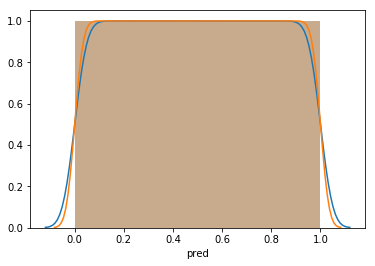

In [9]:
sns.distplot(X_train.pred)
sns.distplot(X_test.pred)

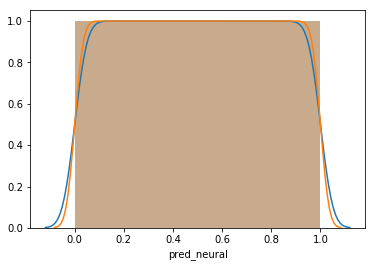

In [10]:
sns.distplot(X_train.pred_neural)
sns.distplot(X_test.pred_neural)

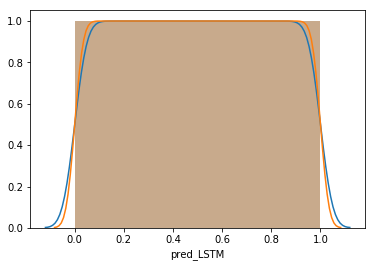

In [11]:
sns.distplot(X_train.pred_LSTM)
sns.distplot(X_test.pred_LSTM)

In [12]:
model = LogisticRegression()
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
model.fit(X_train, y_train)
train_pred_prob = model.predict_proba(X_train)[:,1]
test_pred_prob = model.predict_proba(X_test)[:,1]

model.coef_

/home/zdeploy/anaconda3/envs/py36_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[ 1.14455943,  4.32945542, -0.01096546,  3.03052265,  0.71854519,
         0.41416783,  0.11545012, -0.17728214]])

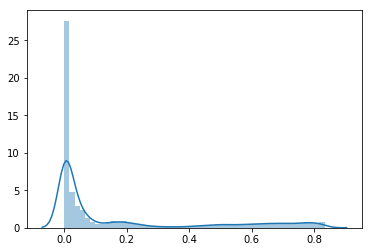

In [14]:
sns.distplot(train_pred_prob)

In [31]:
thres = 0.43
train_pred = train_pred_prob > thres

c = Counter(train_pred)
print(c[1]*100/c[0])

f1_score(y_train, train_pred)

26.640093786635404


0.7275858769495741

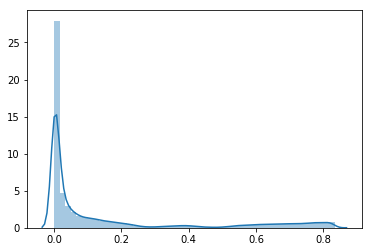

In [16]:
sns.distplot(test_pred_prob)

In [32]:
thres = 0.43
y_pred = test_pred_prob > thres

Counter(y_pred)

Counter({False: 144040, True: 29472})

In [33]:
submission_df = pd.DataFrame({'Id': range(1, len(y_pred)+1), 'ClassLabel': y_pred})
submission_df.ClassLabel = submission_df.ClassLabel.astype(int)
print(submission_df.shape)
print(Counter(submission_df.ClassLabel))
submission_df.head()

(173512, 2)
Counter({0: 144040, 1: 29472})


,Id,ClassLabel
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [34]:
x = submit_neural.pred_neural > 0.16
sum(x ==y_pred)/len(x)

0.9825084144036147

In [35]:
### Write file
submission_df.to_csv("stacking_6_rank.csv", index=False)
Counter(submission_df.ClassLabel)

Counter({0: 144040, 1: 29472})